In [ ]:
#sub55のnotebook

In [ ]:
#!pip install optuna

In [ ]:
class config:
    run_type = 'colab'
    random_seed = 2022
    nfold = 5
    target = 'pm25_mid'

In [ ]:
import os
import re
from IPython.lib import kernel
from requests import get

if config.run_type == 'colab':
    from google.colab import drive, files
    
    drive.mount('/content/drive')
    #ご自身のフォルダパスを指定
    Drive = "/content/drive/My Drive/python/sony/"
    Exp = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'][:-6]
    Exp = re.sub('.ip', '', Exp)
        
Input = os.path.join(Drive, 'input')
Output = os.path.join(Drive, 'output')
Output_Exp = os.path.join(Output, Exp)
Output_Model = os.path.join(Output_Exp, "model")
Output_Preds = os.path.join(Output_Exp, "preds")
Output_Feats = os.path.join(Output_Exp, "feats")

Submission = os.path.join(Drive, "submission")

dirs = [Output_Model, Output_Preds, Output_Feats]
for d in dirs:
    if not os.path.isdir(d):
        os.makedirs(d, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import gc
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import datetime

from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
#import optuna.integration.lightgbm as opt_lgb

pd.set_option('max_rows', 400)
pd.set_option('max_columns', 200)

In [ ]:
train_data = pd.read_csv(os.path.join(Input, 'train.csv'))\
               .assign(timestamp=lambda d: pd.to_datetime(d['year'].astype(str) + '-' + d['month'].astype(str) + '-' + d['day'].astype(str)))
test_data = pd.read_csv(os.path.join(Input, 'test.csv'))\
               .assign(timestamp=lambda d: pd.to_datetime(d['year'].astype(str) + '-' + d['month'].astype(str) + '-' + d['day'].astype(str)))

In [ ]:
df_all = pd.concat([train_data,test_data],sort=False)

In [ ]:
co2 = pd.read_csv(os.path.join(Input, 'owid-co2-data.csv'))

In [ ]:
print(co2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     93 non-null     object 
 1   year        93 non-null     int64  
 2   co2         93 non-null     float64
 3   population  93 non-null     int64  
 4   gdp         31 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 3.8+ KB
None


In [ ]:
co2_2018 = co2[co2['year']==2018]
gdp = co2_2018[['country','gdp']]

In [ ]:
co2_2020 = co2[co2['year']==2020]

In [ ]:
co2_2020 = co2_2020.drop(['gdp'],axis=1)

In [ ]:
co2_2020 = co2_2020.rename(columns={'country': 'Country'})

In [ ]:
df_all = pd.merge(df_all,co2_2020,on='Country',how='left')

In [ ]:
df_all = df_all.drop(['id','year_y'],axis=1)

In [ ]:
df_all = pd.merge(df_all,gdp,left_on ='Country',right_on = 'country',how='left')

In [ ]:
df_all = df_all.drop(['country'],axis=1)

In [ ]:
df_all = df_all.rename(columns={'year_x': 'year'})

In [ ]:
print(df_all)

        year  month  day         Country       City       lat        lon  \
0       2019      1    1       Australia   Brisbane -27.46794  153.02809   
1       2019      1    1       Australia     Darwin -12.46113  130.84185   
2       2019      1    1       Australia  Melbourne -37.81400  144.96332   
3       2019      1    1       Australia  Newcastle -32.92953  151.78010   
4       2019      1    1       Australia      Perth -31.95224  115.86140   
...      ...    ...  ...             ...        ...       ...        ...   
249445  2021     12   31          Turkey      Adana  36.98615   35.32531   
249446  2021     12   31          Turkey      Bursa  40.19559   29.06013   
249447  2021     12   31          Turkey    Trabzon  41.00500   39.72694   
249448  2021     12   31  United Kingdom     London  51.50853   -0.12574   
249449  2021     12   31         Vietnam   Haiphong  20.86481  106.68345   

        co_cnt  co_min  co_mid  co_max  co_var  o3_cnt  o3_min  o3_mid  \
0           3

In [ ]:
print(df_all.isnull().sum())

year                   0
month                  0
day                    0
Country                0
City                   0
lat                    0
lon                    0
co_cnt                 0
co_min                 0
co_mid                 0
co_max                 0
co_var                 0
o3_cnt                 0
o3_min                 0
o3_mid                 0
o3_max                 0
o3_var                 0
so2_cnt                0
so2_min                0
so2_mid                0
so2_max                0
so2_var                0
no2_cnt                0
no2_min                0
no2_mid                0
no2_max                0
no2_var                0
temperature_cnt        0
temperature_min        0
temperature_mid        0
temperature_max        0
temperature_var        0
humidity_cnt           0
humidity_min           0
humidity_mid           0
humidity_max           0
humidity_var           0
pressure_cnt           0
pressure_min           0
pressure_mid           0


In [ ]:
train_data = df_all.iloc[:len(train_data)]
test_data = df_all.iloc[len(train_data):].reset_index(drop=True)

In [ ]:
def make_corr_array(df, cols):
    output = pd.DataFrame(1 - squareform(pdist(df[cols].T, 'correlation')),
                          columns=cols, index=cols)
    return output

In [ ]:
corr_df = make_corr_array(train_data, [c for c in train_data.columns if re.search(r'mid|min|max|cnt|var|lat|lon|energy', c)])

In [ ]:
corr_top10 = corr_df.loc[:, ['pm25_mid']].assign(abs_value=lambda d: np.abs(d['pm25_mid']))\
                    .sort_values('abs_value', ascending=False)\
                    .iloc[1:11, :].index.tolist()

In [ ]:
class AbstractBaseBlock:
    def fit(self, input_df: pd.DataFrame, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError()

In [ ]:
class NumericFeatBlock(AbstractBaseBlock):
    def __init__(self, col: str):
        self.col = col
        
    def fit(self, input_df, y=None):
        pass
        
    def transform(self, input_df):
        return input_df.loc[:, self.col]

In [ ]:
class CategoricalFeatBlock(AbstractBaseBlock):
    def __init__(self, col: str, whole_df = None, threshold=0.001, is_label=True, is_dummy=False):
        self.col = col
        self.whole_df = whole_df
        self.threshold = threshold
        self.is_label = is_label
        self.is_dummy = is_dummy
    
    def fit(self, input_df, y=None):
        if self.whole_df == None:
            df = input_df.loc[:, self.col]
        else:
            df = self.whole_df.loc[:, self.col]
        vc = df.value_counts(normalize=True).reset_index()
        vc = vc.assign(thresh=lambda d: np.where(d[self.col].values >= self.threshold, 1, 0))\
               .assign(thresh=lambda d: d['thresh'].cumsum() - d['thresh'])
        self.label_dict_ = dict(vc[['index', 'thresh']].values)
        self.label_other_ = np.max(self.label_dict_.values())
        
        return self.transform(input_df)
        
    def transform(self, input_df):
        out_df = pd.DataFrame()
        label_df = pd.DataFrame()
        label_df[f'{self.col}_label_enc'] = np.vectorize(lambda x: self.label_dict_.get(x, self.label_other_))\
                                                        (input_df[self.col].values)
        if self.is_label:
            out_df = pd.concat([out_df, label_df], axis=1)
            
        if self.is_dummy:
            label_df[f'{self.col}_label_enc'] = label_df[f'{self.col}_label_enc'].astype(object)
            out_df = pd.concat([out_df, pd.get_dummies(label_df)], axis=1)
        
        return out_df

In [ ]:
class DateFeatureBlock(AbstractBaseBlock):
    def __init__(self, is_get_weekday=True):
        self.is_get_weekday = is_get_weekday
        
    def fit(self, input_df, y=None):
        pass
        
    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df = input_df[['year', 'month', 'day']]
        if self.is_get_weekday:
            out_df = out_df.assign(weekday=[x.dayofweek for x in input_df['timestamp'].tolist()])
        
        return out_df

In [ ]:
class AggregateValueBlock(AbstractBaseBlock):
    def __init__(self, key_col, agg_dict, whole_df=None):
        self.key_col = key_col
        self.agg_dict = agg_dict
        self.whole_df = whole_df
        
    def fit(self, input_df, y=None):
        if self.whole_df == None:
            df = input_df
        else:
            df = self.whole_df
        agg_df = df.groupby(self.key_col).agg(self.agg_dict)
        agg_df.columns = ['_'.join(c) for c in agg_df.columns]
        self.agg_df_ = agg_df.add_prefix('_')\
                             .add_prefix('_'.join(self.key_col))\
                             .add_prefix('agg_').reset_index()
        
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df = pd.merge(input_df[self.key_col], self.agg_df_, how='left', on=self.key_col)\
                   .drop(self.key_col, axis=1)\
                   .fillna(0)
        
        return out_df

In [ ]:
numeric_columns = [c for c in train_data.columns if re.search(r'max|mid|min|cnt|var|lat|lon|energy', c) and not re.search(r'pm25', c)]
categorical_columns = ['Country']
agg_country_value = dict([(c, [np.mean, np.max, np.min, np.std, np.var]) for c in corr_top10])

In [ ]:
run_blocks = [
    *[NumericFeatBlock(c) for c in [numeric_columns]],
    *[CategoricalFeatBlock(c) for c in categorical_columns],
    *[DateFeatureBlock()],
    *[AggregateValueBlock(['Country', 'month'], agg_country_value)],    
]

In [ ]:
def get_train_data(input_df, feat_blocks, y=None, fit_df=None):
    if fit_df is None:
        fit_df = input_df.copy()
        
    for block in feat_blocks:
        block.fit(fit_df, y)
        
    out = [block.transform(input_df) for block in feat_blocks]
    out = pd.concat(out, axis=1)
    
    return out

def get_test_data(input_df, feat_blocks):
    
    out = [block.transform(input_df) for block in feat_blocks]
    out = pd.concat(out, axis=1)
    
    return out

In [ ]:
df_train = get_train_data(train_data, run_blocks, fit_df=pd.concat([train_data, test_data], ignore_index=True))
df_train

,lat,lon,co_cnt,co_min,co_mid,co_max,co_var,o3_cnt,o3_min,o3_mid,o3_max,o3_var,so2_cnt,so2_min,so2_mid,so2_max,so2_var,no2_cnt,no2_min,no2_mid,no2_max,no2_var,temperature_cnt,temperature_min,temperature_mid,temperature_max,temperature_var,humidity_cnt,humidity_min,humidity_mid,humidity_max,humidity_var,pressure_cnt,pressure_min,pressure_mid,pressure_max,pressure_var,ws_cnt,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,population,Country_label_enc,year,...,agg_Country_month_no2_mid_mean,agg_Country_month_no2_mid_amax,agg_Country_month_no2_mid_amin,agg_Country_month_no2_mid_std,agg_Country_month_no2_mid_var,agg_Country_month_co_mid_mean,agg_Country_month_co_mid_amax,agg_Country_month_co_mid_amin,agg_Country_month_co_mid_std,agg_Country_month_co_mid_var,agg_Country_month_no2_max_mean,agg_Country_month_no2_max_amax,agg_Country_month_no2_max_amin,agg_Country_month_no2_max_std,agg_Country_month_no2_max_var,agg_Country_month_no2_min_mean,agg_Country_month_no2_min_amax,agg_Country_month_no2_min_amin,agg_Country_month_no2_min_std,agg_Country_month_no2_min_var,agg_Country_month_co_max_mean,agg_Country_month_co_max_amax,agg_Country_month_co_max_amin,agg_Country_month_co_max_std,agg_Country_month_co_max_var,agg_Country_month_population_mean,agg_Country_month_population_amax,agg_Country_month_population_amin,agg_Country_month_population_std,agg_Country_month_population_var,agg_Country_month_so2_max_mean,agg_Country_month_so2_max_amax,agg_Country_month_so2_max_amin,agg_Country_month_so2_max_std,agg_Country_month_so2_max_var,agg_Country_month_ws_mid_mean,agg_Country_month_ws_mid_amax,agg_Country_month_ws_mid_amin,agg_Country_month_ws_mid_std,agg_Country_month_ws_mid_var,agg_Country_month_so2_mid_mean,agg_Country_month_so2_mid_amax,agg_Country_month_so2_mid_amin,agg_Country_month_so2_mid_std,agg_Country_month_so2_mid_var,agg_Country_month_o3_max_mean,agg_Country_month_o3_max_amax,agg_Country_month_o3_max_amin,agg_Country_month_o3_max_std,agg_Country_month_o3_max_var
0,-27.46794,153.02809,38,0.749,2.590,2.633,0.850,29,2.397,4.295,5.916,3.017,11,0.149,0.468,0.900,0.137,36,0.000,0.529,2.188,1.167,36,10.956,14.038,20.866,23.880,45,30.207,70.426,94.202,994.051,59,1004.137,1015.721,1023.398,89.588,42,0.241,1.088,3.101,1.983,17,7.671,10.358,15.112,13.424,25499881,10,2019,...,6.669456,38.018,0.095,6.389357,40.823877,3.256152,20.272,0.040,3.104306,9.636714,17.718835,67.282,0.096,13.110455,171.884028,2.492414,17.962,0.000,3.422229,11.711652,6.240017,42.192,0.069,5.745370,33.009279,25499881.0,25499881,25499881,0.0,0.0,7.232384,54.925,0.099,8.029337,64.470248,2.669814,8.075,0.000,1.469563,2.159616,2.385929,18.539,0.094,2.142337,4.589608,28.888395,113.124,0.000,18.787270,352.961502
1,-12.46113,130.84185,47,2.594,3.181,4.828,1.208,49,3.092,7.572,12.332,20.524,31,0.096,0.102,16.152,61.550,45,0.099,0.301,5.411,6.401,71,24.113,30.125,36.678,37.327,50,49.034,74.276,92.975,467.112,69,938.085,970.252,1080.000,7.320,48,0.828,3.473,7.396,10.411,62,21.324,23.813,24.221,2.021,25499881,10,2019,...,6.669456,38.018,0.095,6.389357,40.823877,3.256152,20.272,0.040,3.104306,9.636714,17.718835,67.282,0.096,13.110455,171.884028,2.492414,17.962,0.000,3.422229,11.711652,6.240017,42.192,0.069,5.745370,33.009279,25499881.0,25499881,25499881,0.0,0.0,7.232384,54.925,0.099,8.029337,64.470248,2.669814,8.075,0.000,1.469563,2.159616,2.385929,18.539,0.094,2.142337,4.589608,28.888395,113.124,0.000,18.787270,352.961502
2,-37.81400,144.96332,17,1.190,1.197,2.200,0.248,123,0.736,12.527,23.432,125.224,36,1.392,1.464,47.652,515.570,111,0.972,2.751,12.230,30.518,148,0.000,0.000,23.226,131.280,138,25.919,69.069,100.000,1292.191,153,880.000,880.000,1018.200,4655.348,125,0.000,2.107,8.089,15.719,22,10.309,13.133,15.422,6.355,25499881,10,2019,...,6.669456,38.018,0.095,6.389357,40.823877,3.256152,20.272,0.040,3.104306,9.636714,17.718835,67.282,0.096,13.110455,171.884028,2.492414,17.962,0.000,3.422229,11.711652,6.240017,42.192,0.069,5.745370,33.009279,25499881.0,25499881,25499

In [ ]:
df_test = get_test_data(test_data, run_blocks)
df_test

,lat,lon,co_cnt,co_min,co_mid,co_max,co_var,o3_cnt,o3_min,o3_mid,o3_max,o3_var,so2_cnt,so2_min,so2_mid,so2_max,so2_var,no2_cnt,no2_min,no2_mid,no2_max,no2_var,temperature_cnt,temperature_min,temperature_mid,temperature_max,temperature_var,humidity_cnt,humidity_min,humidity_mid,humidity_max,humidity_var,pressure_cnt,pressure_min,pressure_mid,pressure_max,pressure_var,ws_cnt,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,population,Country_label_enc,year,...,agg_Country_month_no2_mid_mean,agg_Country_month_no2_mid_amax,agg_Country_month_no2_mid_amin,agg_Country_month_no2_mid_std,agg_Country_month_no2_mid_var,agg_Country_month_co_mid_mean,agg_Country_month_co_mid_amax,agg_Country_month_co_mid_amin,agg_Country_month_co_mid_std,agg_Country_month_co_mid_var,agg_Country_month_no2_max_mean,agg_Country_month_no2_max_amax,agg_Country_month_no2_max_amin,agg_Country_month_no2_max_std,agg_Country_month_no2_max_var,agg_Country_month_no2_min_mean,agg_Country_month_no2_min_amax,agg_Country_month_no2_min_amin,agg_Country_month_no2_min_std,agg_Country_month_no2_min_var,agg_Country_month_co_max_mean,agg_Country_month_co_max_amax,agg_Country_month_co_max_amin,agg_Country_month_co_max_std,agg_Country_month_co_max_var,agg_Country_month_population_mean,agg_Country_month_population_amax,agg_Country_month_population_amin,agg_Country_month_population_std,agg_Country_month_population_var,agg_Country_month_so2_max_mean,agg_Country_month_so2_max_amax,agg_Country_month_so2_max_amin,agg_Country_month_so2_max_std,agg_Country_month_so2_max_var,agg_Country_month_ws_mid_mean,agg_Country_month_ws_mid_amax,agg_Country_month_ws_mid_amin,agg_Country_month_ws_mid_std,agg_Country_month_ws_mid_var,agg_Country_month_so2_mid_mean,agg_Country_month_so2_mid_amax,agg_Country_month_so2_mid_amin,agg_Country_month_so2_mid_std,agg_Country_month_so2_mid_var,agg_Country_month_o3_max_mean,agg_Country_month_o3_max_amax,agg_Country_month_o3_max_amin,agg_Country_month_o3_max_std,agg_Country_month_o3_max_var
0,-34.92866,138.59863,155,0.091,0.101,0.195,0.003,167,0.000,0.000,0.000,0.000,12,0.095,0.098,0.106,0.000,118,0.097,0.099,0.105,0.000,168,13.226,23.461,33.922,104.054,180,17.795,34.081,90.636,1282.735,154,934.478,944.740,1029.990,11.067,111,0.098,2.411,10.213,24.608,26,3.057,8.180,15.841,39.705,25499881,10,2019,...,6.669456,38.018,0.095,6.389357,40.823877,3.256152,20.272,0.040,3.104306,9.636714,17.718835,67.282,0.096,13.110455,171.884028,2.492414,17.962,0.000,3.422229,11.711652,6.240017,42.192,0.069,5.745370,33.009279,25499881.0,25499881,25499881,0.0,0.0,7.232384,54.925,0.099,8.029337,64.470248,2.669814,8.075,0.000,1.469563,2.159616,2.385929,18.539,0.094,2.142337,4.589608,28.888395,113.124,0.000,18.787270,352.961502
1,-33.86785,151.20732,23,1.037,2.272,3.391,1.347,142,7.797,34.414,59.489,630.329,54,1.476,1.531,5.380,3.709,147,1.139,4.117,24.680,132.975,176,21.676,27.487,36.453,52.606,177,30.139,55.590,87.970,805.448,184,979.216,1008.498,1014.100,65.343,158,0.101,2.982,8.261,15.957,47,11.090,15.361,19.227,15.857,25499881,10,2019,...,6.669456,38.018,0.095,6.389357,40.823877,3.256152,20.272,0.040,3.104306,9.636714,17.718835,67.282,0.096,13.110455,171.884028,2.492414,17.962,0.000,3.422229,11.711652,6.240017,42.192,0.069,5.745370,33.009279,25499881.0,25499881,25499881,0.0,0.0,7.232384,54.925,0.099,8.029337,64.470248,2.669814,8.075,0.000,1.469563,2.159616,2.385929,18.539,0.094,2.142337,4.589608,28.888395,113.124,0.000,18.787270,352.961502
2,50.85045,4.34878,28,0.096,0.101,0.104,0.000,114,7.064,16.576,27.246,97.445,9,0.566,0.600,0.626,0.000,151,1.362,5.372,16.268,53.080,172,5.402,7.786,9.754,4.564,163,70.948,80.069,96.067,148.232,159,936.950,1047.096,1080.000,19.318,64,0.218,1.200,5.802,7.584,44,1.055,4.411,6.955,8.415,11589616,17,2019,...,10.718637,34.456,0.701,6.124120,37.504847,2.430248,24.154,0.055,3.311313,10.964791,23.987704,70.249,0.796,11.040255,121.887233,3.781977,27.271,0.000,3.899824,15.208628,4.990093,33.494,0.065,6.365361,40.517821,11589616.0,11589616,11

In [ ]:
df_all = pd.concat([df_train,df_test],sort=False)

In [ ]:

#df_all['diff_no2_mid_aggmean'] = df_all['agg_Country_month_no2_mid_mean'] - df_all['no2_mid']
#df_all['diff_no2_mid_aggamax'] = df_all['agg_Country_month_no2_mid_amax'] - df_all['no2_mid']
df_all['diff_no2_mid_aggamin'] = df_all['agg_Country_month_no2_mid_amin'] - df_all['no2_mid']

#df_all['diff_no2_mid_aggminmax'] = df_all['diff_no2_mid_aggamax'] - df_all['diff_no2_mid_aggamin']
#df_all['ratio_no2_mid_aggminmax_mean'] = df_all['diff_no2_mid_aggminmax'] / df_all['diff_no2_mid_aggmean']

#df_all['diff_no2_max_aggmean'] = df_all['agg_Country_month_no2_max_mean'] - df_all['no2_max']
#df_all['diff_no2_max_aggamax'] = df_all['agg_Country_month_no2_max_amax'] - df_all['no2_max']
#df_all['diff_no2_max_aggamin'] = df_all['agg_Country_month_no2_max_amin'] - df_all['no2_max']

#df_all['diff_no2_max_aggminmax'] = df_all['diff_no2_max_aggamax'] - df_all['diff_no2_max_aggamin']
#df_all['ratio_no2_max_aggminmax_mean'] = df_all['diff_no2_max_aggminmax'] / df_all['diff_no2_max_aggmean']

#df_all['diff_no2_min_aggmean'] = df_all['agg_Country_month_no2_min_mean'] - df_all['no2_min']
#df_all['diff_no2_min_aggamax'] = df_all['agg_Country_month_no2_min_amax'] - df_all['no2_min']
#df_all['diff_no2_min_aggamin'] = df_all['agg_Country_month_no2_min_amin'] - df_all['no2_min']

#df_all['diff_no2_min_aggminmax'] = df_all['diff_no2_min_aggamax'] - df_all['diff_no2_min_aggamin']
#df_all['ratio_no2_min_aggminmax_mean'] = df_all['diff_no2_min_aggminmax'] / df_all['diff_no2_min_aggmean']

#df_all['diff_no2_minmax_aggmean'] = df_all['diff_no2_max_aggmean'] -df_all['diff_no2_min_aggmean']
#df_all['diff_no2_minmax_aggamax'] = df_all['diff_no2_max_aggamax'] -df_all['diff_no2_min_aggamax']
#df_all['diff_no2_minmax_aggamin'] = df_all['diff_no2_max_aggamin'] -df_all['diff_no2_min_aggamin']

#df_all['diff_co_mid_aggmean'] = df_all['agg_Country_month_co_mid_mean'] - df_all['co_mid']
#df_all['diff_co_mid_aggamax'] = df_all['agg_Country_month_co_mid_amax'] - df_all['co_mid']
df_all['diff_co_mid_aggamin'] = df_all['agg_Country_month_co_mid_amin'] - df_all['co_mid']

#df_all['diff_co_mid_aggminmax'] = df_all['diff_co_mid_aggamax'] - df_all['diff_co_mid_aggamin']
#df_all['ratio_co_mid_aggminmax_mean'] = df_all['diff_co_mid_aggminmax'] / df_all['diff_co_mid_aggmean']

#df_all['diff_co_max_aggmean'] = df_all['agg_Country_month_co_max_mean'] - df_all['co_max']
#df_all['diff_co_max_aggamax'] = df_all['agg_Country_month_co_max_amax'] - df_all['co_max']
df_all['diff_co_max_aggamin'] = df_all['agg_Country_month_co_max_amin'] - df_all['co_max']

#df_all['diff_co_max_aggminmax'] = df_all['diff_co_max_aggamax'] - df_all['diff_co_max_aggamin']
#df_all['ratio_co_max_aggminmax_mean'] = df_all['diff_co_max_aggminmax'] / df_all['diff_co_max_aggmean']

#df_all['diff_co_min_aggmean'] = df_all['agg_Country_month_co_min_mean'] - df_all['co_min']
#df_all['diff_co_min_aggamax'] = df_all['agg_Country_month_co_min_amax'] - df_all['co_min']
#df_all['diff_co_min_aggamin'] = df_all['agg_Country_month_co_min_amin'] - df_all['co_min']
'''

#df_all['diff_co_min_aggminmax'] = df_all['diff_co_min_aggamax'] - df_all['diff_co_min_aggamin']
#df_all['ratio_co_min_aggminmax_mean'] = df_all['diff_co_min_aggminmax'] / df_all['diff_co_min_aggmean']

#df_all['diff_co_minmax_aggmean'] = df_all['diff_co_max_aggmean'] -df_all['diff_co_min_aggmean']
#df_all['diff_co_minmax_aggamax'] = df_all['diff_co_max_aggamax'] -df_all['diff_co_min_aggamax']
#df_all['diff_co_minmax_aggamin'] = df_all['diff_co_max_aggamin'] -df_all['diff_co_min_aggamin']

#df_all['diff_so2_max_aggmean'] = df_all['agg_Country_month_so2_max_mean'] - df_all['so2_max']
#df_all['diff_so2_max_aggamax'] = df_all['agg_Country_month_so2_max_amax'] - df_all['so2_max']
df_all['diff_so2_max_aggamin'] = df_all['agg_Country_month_so2_max_amin'] - df_all['so2_max']

#df_all['diff_so2_max_aggminmax'] = df_all['diff_so2_max_aggamax'] - df_all['diff_so2_max_aggamin']
#df_all['ratio_so2_max_aggminmax_mean'] = df_all['diff_so2_max_aggminmax'] / df_all['diff_so2_max_aggmean']

#df_all['diff_so2_mid_aggmean'] = df_all['agg_Country_month_so2_mid_mean'] - df_all['so2_mid']
#df_all['diff_so2_mid_aggamax'] = df_all['agg_Country_month_so2_mid_amax'] - df_all['so2_mid']
df_all['diff_so2_mid_aggamin'] = df_all['agg_Country_month_so2_mid_amin'] - df_all['so2_mid']

#df_all['diff_so2_mid_aggminmax'] = df_all['diff_so2_mid_aggamax'] - df_all['diff_so2_mid_aggamin']
#df_all['ratio_so2_mid_aggminmax_mean'] = df_all['diff_so2_mid_aggminmax'] / df_all['diff_so2_mid_aggmean']

df_all['diff_o3_max_aggmean'] = df_all['agg_Country_month_o3_max_mean'] - df_all['o3_max']
#df_all['diff_o3_max_aggamax'] = df_all['agg_Country_month_o3_max_amax'] - df_all['o3_max']
df_all['diff_o3_max_aggamin'] = df_all['agg_Country_month_o3_max_amin'] - df_all['o3_max']

df_all['diff_o3_max_aggminmax'] = df_all['diff_o3_max_aggamax'] - df_all['diff_o3_max_aggamin']
df_all['ratio_o3_max_aggminmax_mean'] = df_all['diff_o3_max_aggminmax'] / df_all['diff_o3_max_aggmean']

df_all['diff_ws_mid_aggmean'] = df_all['agg_Country_month_ws_mid_mean'] - df_all['ws_mid']
df_all['diff_ws_mid_aggamax'] = df_all['agg_Country_month_ws_mid_amax'] - df_all['ws_mid']
df_all['diff_ws_mid_aggamin'] = df_all['agg_Country_month_ws_mid_amin'] - df_all['ws_mid']

df_all['diff_ws_mid_aggminmax'] = df_all['diff_ws_mid_aggamax'] - df_all['diff_ws_mid_aggamin']
df_all['ratio_ws_mid_aggminmax_mean'] = df_all['diff_ws_mid_aggminmax'] / df_all['diff_ws_mid_aggmean']
'''

"\n\n#df_all['diff_co_min_aggminmax'] = df_all['diff_co_min_aggamax'] - df_all['diff_co_min_aggamin']\n#df_all['ratio_co_min_aggminmax_mean'] = df_all['diff_co_min_aggminmax'] / df_all['diff_co_min_aggmean']\n\n#df_all['diff_co_minmax_aggmean'] = df_all['diff_co_max_aggmean'] -df_all['diff_co_min_aggmean']\n#df_all['diff_co_minmax_aggamax'] = df_all['diff_co_max_aggamax'] -df_all['diff_co_min_aggamax']\n#df_all['diff_co_minmax_aggamin'] = df_all['diff_co_max_aggamin'] -df_all['diff_co_min_aggamin']\n\n#df_all['diff_so2_max_aggmean'] = df_all['agg_Country_month_so2_max_mean'] - df_all['so2_max']\n#df_all['diff_so2_max_aggamax'] = df_all['agg_Country_month_so2_max_amax'] - df_all['so2_max']\ndf_all['diff_so2_max_aggamin'] = df_all['agg_Country_month_so2_max_amin'] - df_all['so2_max']\n\n#df_all['diff_so2_max_aggminmax'] = df_all['diff_so2_max_aggamax'] - df_all['diff_so2_max_aggamin']\n#df_all['ratio_so2_max_aggminmax_mean'] = df_all['diff_so2_max_aggminmax'] / df_all['diff_so2_max_aggme

In [ ]:

df_all['co_minmax'] = df_all['co_max'] - df_all['co_min']
df_all['o3_minmax'] = df_all['o3_max'] - df_all['o3_min']
df_all['so2_minmax'] = df_all['so2_max'] - df_all['so2_min']
df_all['no2_minmax'] = df_all['no2_max'] - df_all['no2_min']

df_all['temperature_minmax'] = df_all['temperature_max'] - df_all['temperature_min']
df_all['humidity_minmax'] = df_all['humidity_max'] - df_all['humidity_min']
df_all['pressure_minmax'] = df_all['pressure_max'] - df_all['pressure_min']
df_all['ws_minmax'] = df_all['ws_max'] - df_all['ws_min']
df_all['dew_minmax'] = df_all['dew_max'] - df_all['dew_min']


df_all['co_mean_mid'] = df_all['co_min'] + df_all['co_minmax']/2 - df_all['co_mid']
df_all['o3_mean_mid'] = df_all['o3_min'] + df_all['o3_minmax']/2 - df_all['o3_mid']
df_all['so2_mean_mid'] = df_all['so2_min'] + df_all['so2_minmax']/2 - df_all['so2_mid']
df_all['no2_mean_mid'] = df_all['no2_min'] + df_all['no2_minmax']/2 - df_all['no2_mid']

df_all['temperature_mean_mid'] = df_all['temperature_min'] + df_all['temperature_minmax']/2 - df_all['temperature_mid']
df_all['humidity_mean_mid'] = df_all['humidity_min'] + df_all['humidity_minmax']/2 - df_all['humidity_mid']
df_all['pressure_mean_mid'] = df_all['pressure_min'] + df_all['pressure_minmax']/2 - df_all['pressure_mid']
df_all['ws_mean_mid'] = df_all['ws_min'] + df_all['ws_minmax']/2 - df_all['ws_mid']

df_all['co_humidity'] = df_all['co_mid']*df_all['humidity_mid']/100
df_all['o3_humidity'] = df_all['o3_mid']*df_all['humidity_mid']/100
df_all['so2_humidity'] = df_all['so2_mid']*df_all['humidity_mid']/100
df_all['no2_humidity'] = df_all['no2_mid']*df_all['humidity_mid']/100
'''
df_all['co_ws'] = df_all['co_mid']*df_all['ws_mid']
df_all['o3_ws'] = df_all['o3_mid']*df_all['ws_mid']
df_all['so2_ws'] = df_all['so2_mid']*df_all['ws_mid']
df_all['no2_ws'] = df_all['no2_mid']*df_all['ws_mid']

df_all['temperature_humidity'] = df_all['temperature_mid']*df_all['humidity_mid']

df_all['cnt'] = df_all['co_cnt']*df_all['o3_cnt']*df_all['so2_cnt']*df_all['no2_cnt']*df_all['temperature_cnt']*df_all['humidity_cnt']*df_all['pressure_cnt']*df_all['ws_cnt']
'''

"\ndf_all['co_ws'] = df_all['co_mid']*df_all['ws_mid']\ndf_all['o3_ws'] = df_all['o3_mid']*df_all['ws_mid']\ndf_all['so2_ws'] = df_all['so2_mid']*df_all['ws_mid']\ndf_all['no2_ws'] = df_all['no2_mid']*df_all['ws_mid']\n\ndf_all['temperature_humidity'] = df_all['temperature_mid']*df_all['humidity_mid']\n\ndf_all['cnt'] = df_all['co_cnt']*df_all['o3_cnt']*df_all['so2_cnt']*df_all['no2_cnt']*df_all['temperature_cnt']*df_all['humidity_cnt']*df_all['pressure_cnt']*df_all['ws_cnt']\n"

In [ ]:

def encode(df, col):
    # この方法だと場合によって最大値が変化するデータでは正確な値は出ない
    # 例：月の日数が30日や31日の場合がある
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df

df_all = encode(df_all, 'weekday')
df_all = encode(df_all, 'day')
df_all = encode(df_all, 'month')
df_all = encode(df_all, 'year')


In [ ]:
'''
group =['Country_label_enc']
feature_cols = ['co_mid', 'no2_mid']

outputs = [df_all]
grp_df = df_all.groupby(group)[feature_cols]

for lag in [-3,-2, -1, 1, 2,3]:
   # shift
   outputs.append(grp_df.shift(lag).add_prefix(f'shift{lag}_'))
   # diff
   outputs.append(grp_df.diff(lag).add_prefix(f'diff{lag}_'))


# rolling
for window in [3,30]:
    tmp_df = grp_df.rolling(window, min_periods=1)
    # 移動平均を取る
    tmp_df = tmp_df.mean().add_prefix(f'rolling{window}_mean_')
    outputs.append(tmp_df.reset_index(drop=True))


df_all = df_all.loc[~df_all.index.duplicated(keep='first')]
df_all = pd.concat(outputs,axis=1)

#https://stackoverflow.com/questions/71240439/reindexing-only-valid-with-uniquely-valued-index-objects
'''

"\ngroup =['Country_label_enc']\nfeature_cols = ['co_mid', 'no2_mid']\n\noutputs = [df_all]\ngrp_df = df_all.groupby(group)[feature_cols]\n\nfor lag in [-3,-2, -1, 1, 2,3]:\n   # shift\n   outputs.append(grp_df.shift(lag).add_prefix(f'shift{lag}_'))\n   # diff\n   outputs.append(grp_df.diff(lag).add_prefix(f'diff{lag}_'))\n\n\n# rolling\nfor window in [3,30]:\n    tmp_df = grp_df.rolling(window, min_periods=1)\n    # 移動平均を取る\n    tmp_df = tmp_df.mean().add_prefix(f'rolling{window}_mean_')\n    outputs.append(tmp_df.reset_index(drop=True))\n\n\ndf_all = df_all.loc[~df_all.index.duplicated(keep='first')]\ndf_all = pd.concat(outputs,axis=1)\n\n#https://stackoverflow.com/questions/71240439/reindexing-only-valid-with-uniquely-valued-index-objects\n"

In [ ]:
print(df_all)

            lat        lon  co_cnt  co_min  co_mid  co_max  co_var  o3_cnt  \
0     -27.46794  153.02809      38   0.749   2.590   2.633   0.850      29   
1     -12.46113  130.84185      47   2.594   3.181   4.828   1.208      49   
2     -37.81400  144.96332      17   1.190   1.197   2.200   0.248     123   
3     -32.92953  151.78010      63   4.586  11.044  14.802  24.186      90   
4     -31.95224  115.86140      47   4.689   8.681  11.100  10.011      83   
...         ...        ...     ...     ...     ...     ...     ...     ...   
53504  36.98615   35.32531      97   4.674   9.034  14.650  23.900      90   
53505  40.19559   29.06013     123  17.621  18.156  21.877   4.390     116   
53506  41.00500   39.72694     150   0.128  14.275  21.124   0.315     108   
53507  51.50853   -0.12574      21   0.057   0.111   2.088   0.988      54   
53508  20.86481  106.68345      47   0.060   0.071   0.136   0.000     134   

       o3_min  o3_mid  o3_max   o3_var  so2_cnt  so2_min  so2_m

In [ ]:
#df_all.plot.scatter('month_sin', 'month_cos').set_aspect('equal')

In [ ]:
df_train = df_all.iloc[:len(df_train)]
df_test = df_all.iloc[len(df_train):].reset_index(drop=True)

In [ ]:
target = train_data[config.target]

In [ ]:
'''
# LightGBM用のデータセットに変換
trainval = opt_lgb.Dataset(df_train, target)

# ハイパーパラメータサーチ&モデル構築
params = {'objective': 'regression',
          'metric': 'rmse',
          'random_seed':42} 

# クロスバリデーションによるハイパーパラメータの探索 3fold
tuner = opt_lgb.LightGBMTunerCV(params, trainval, verbose_eval=100, early_stopping_rounds=100, folds=KFold(n_splits=5))

# ハイパーパラメータ探索の実行
tuner.run()

# サーチしたパラメータの表示
best_params = tuner.best_params
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))
'''

'\n# LightGBM用のデータセットに変換\ntrainval = opt_lgb.Dataset(df_train, target)\n\n# ハイパーパラメータサーチ&モデル構築\nparams = {\'objective\': \'regression\',\n          \'metric\': \'rmse\',\n          \'random_seed\':42} \n\n# クロスバリデーションによるハイパーパラメータの探索 3fold\ntuner = opt_lgb.LightGBMTunerCV(params, trainval, verbose_eval=100, early_stopping_rounds=100, folds=KFold(n_splits=5))\n\n# ハイパーパラメータ探索の実行\ntuner.run()\n\n# サーチしたパラメータの表示\nbest_params = tuner.best_params\nprint("  Params: ")\nfor key, value in best_params.items():\n    print("    {}: {}".format(key, value))\n'

In [ ]:
def group_kfold_split(df, col_group, n_splits, random_state):

    group_id = df[col_group].value_counts().reset_index()
    group_id.columns = [col_group, 'count']
    group_id_list = group_id[col_group].unique()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    kf_list = list(kf.split(group_id_list))
    cv_idx = [(df[col_group].isin(group_id_list[idx_trn]), df[col_group].isin(group_id_list[idx_val])) for idx_trn, idx_val in kf_list]

    return [(df[idx_trn].index.tolist(), df[idx_val].index.tolist()) for idx_trn, idx_val in cv_idx]

In [ ]:
#cross validation strategy
kf = KFold(n_splits=config.nfold, shuffle=True, random_state=config.random_seed)
kf_cv = list(kf.split(train_data))
gkf_cv = group_kfold_split(train_data, 'City', n_splits=config.nfold, random_state=config.random_seed)

In [ ]:
def cal_rmse(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
def fit_lgb(x, y, cv, model_params, fit_params, fobj=None, feval=None):

    models = []
    n_records = y.shape[0]
    oof_pred = np.zeros(n_records, dtype=np.float32)
    fold = 0
    data_labels = [re.sub(r'[",\[\]{}:()]', '_', c) for c in x.columns.tolist()]

    model_params.update(deterministic = True)

    for trn_idx, val_idx in cv:

        fold += 1
        x_train, x_valid = x.iloc[trn_idx].values, x.iloc[val_idx].values
        y_train, y_valid = np.array(y.iloc[trn_idx]), np.array(y.iloc[val_idx])

        lgb_train = lgb.Dataset(x_train, y_train, feature_name=data_labels)
        lgb_valid = lgb.Dataset(x_valid, y_valid, feature_name=data_labels, reference=lgb_train)

        lgb_model = lgb.train(model_params,
                              train_set=lgb_train,
                              valid_sets=[lgb_train, lgb_valid],
                              fobj=fobj,
                              feval=feval,
                              verbose_eval=fit_params['verbose_eval'],
                              num_boost_round=fit_params['num_boost_rounds'],
                              callbacks=[lgb.early_stopping(fit_params['early_stopping_rounds'])],
                              )

        pred_valid = lgb_model.predict(x_valid, num_iteration=lgb_model.best_iteration)
        oof_pred[val_idx] = pred_valid
        models.append(lgb_model)

        print(f' - fold{fold}_RMSE - {cal_rmse(y_valid, pred_valid):4f}')

    print(f' - CV_RMSE - {cal_rmse(oof_pred, np.array(y)):4f}') 

    return oof_pred, models

In [ ]:
'''
#Params: 
    objective: regression
    metric: rmse
    random_seed: 42
    feature_pre_filter: False
    lambda_l1: 0.000338595481765331
    lambda_l2: 9.60230430368646
    num_leaves: 32
    feature_fraction: 0.6799999999999999
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20
'''

'\n#Params: \n    objective: regression\n    metric: rmse\n    random_seed: 42\n    feature_pre_filter: False\n    lambda_l1: 0.000338595481765331\n    lambda_l2: 9.60230430368646\n    num_leaves: 32\n    feature_fraction: 0.6799999999999999\n    bagging_fraction: 1.0\n    bagging_freq: 0\n    min_child_samples: 20\n'

In [ ]:
lgb_model_params = {'boosting_type': 'gbdt',
                
                    'objective': 'rmse',

                    'lambda_l1': 0.000338595481765331,
                    'lambda_l2': 9.60230430368646,
                    'feature_fraction': 0.6799999999999999,

                    'learning_rate': 0.05,
                    'max_depth': -1,
                    'num_leaves': 32,
                    'min_data_in_leaf': 20,
                    'max_bin': 255,
                    
                    'reg_lambda': 1.0,
                    'reg_alpha': 1.,
                   
                    'colsample_bytree': 0.8,
                    'subsample': 0.8,
                    'subsample_freq': 1,
                    
                    'random_state': config.random_seed,
                    'verbose': -1,
                    'n_jobs': -1,
                    }

lgb_fit_params ={'num_boost_rounds': 10000,
                 'early_stopping_rounds': 100,
                 'verbose_eval': 100,
                }

In [ ]:
oof_valid_lgb1, lgb_models1 = fit_lgb(x=df_train, y=target, cv=kf_cv,
                                      model_params=lgb_model_params, fit_params=lgb_fit_params
                                     )

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 20.9962	valid_1's rmse: 21.1165
[200]	training's rmse: 19.879	valid_1's rmse: 20.2482
[300]	training's rmse: 19.262	valid_1's rmse: 19.898
[400]	training's rmse: 18.8171	valid_1's rmse: 19.7066
[500]	training's rmse: 18.4502	valid_1's rmse: 19.5907
[600]	training's rmse: 18.1145	valid_1's rmse: 19.5038
[700]	training's rmse: 17.8064	valid_1's rmse: 19.4309
[800]	training's rmse: 17.5208	valid_1's rmse: 19.3636
[900]	training's rmse: 17.2523	valid_1's rmse: 19.3104
[1000]	training's rmse: 17.0055	valid_1's rmse: 19.2718
[1100]	training's rmse: 16.7657	valid_1's rmse: 19.2306
[1200]	training's rmse: 16.5417	valid_1's rmse: 19.1949
[1300]	training's rmse: 16.3196	valid_1's rmse: 19.1606
[1400]	training's rmse: 16.1069	valid_1's rmse: 19.132
[1500]	training's rmse: 15.9043	valid_1's rmse: 19.1067
[1600]	training's rmse: 15.7123	valid_1's rmse: 19.0812
[1700]	training's rmse: 15.5242	valid_1's rmse: 19.058

In [ ]:
def visualize_importance(models, feat_train_df, file_name):
    
    feature_importance_df = pd.DataFrame()

    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0,
                                          ignore_index=True
                                         )
    
    mean_feature_importance = feature_importance_df.groupby('column').mean().sort_values('feature_importance', ascending=False)
    mean_feature_importance.to_csv(os.path.join(Output_Model, f'feature_importance_{file_name}.csv'), index=True)
    
    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:100]
    
    fig, ax = plt.subplots(figsize=(12, max(8, len(order) * 0.25)))
    sns.boxenplot(data=feature_importance_df,
                  x='feature_importance',
                  y='column',
                  order=order,
                  ax=ax,
                  palette='viridis',
                  orient='h'
                 )
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig, ax

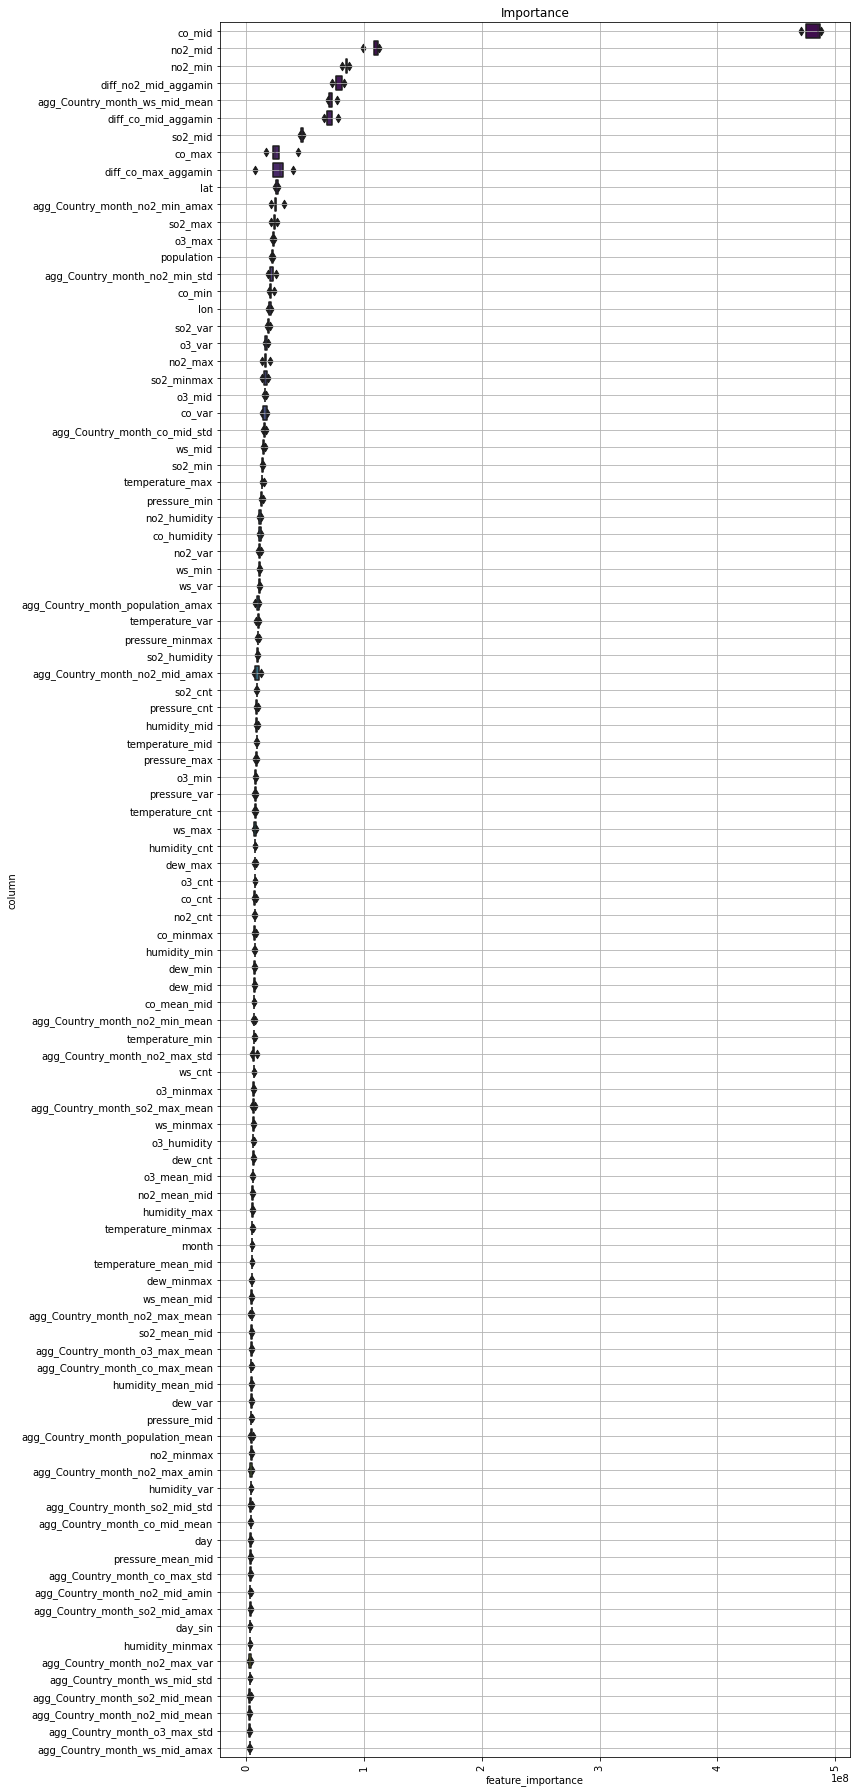

In [ ]:
_ = visualize_importance(lgb_models1, df_train, 'lgb_model')

In [ ]:
def predict_test(models, df):
    out = np.array([model.predict(df) for model in models])
    out = np.mean(out, axis=0)
    
    return out

In [ ]:
pred_test = predict_test(lgb_models1, df_test)

In [ ]:
y_true = target
min_values = y_true.min()
pred_test[pred_test<min_values] = min_values

In [ ]:
#check distribution of train and test_pred data
def plot_prediction_distribution(y_true, y_pred, y_test):
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.histplot(y_test, label='Test Predict', ax=ax, color='black', stat='density')
    sns.histplot(y_pred, label='Out Of Fold', ax=ax, color='C1', stat='density', alpha=0.5)
    sns.histplot(y_true, label='True Value', ax=ax, color='blue', stat='density', alpha=0.5)
    ax.legend()
    ax.grid()

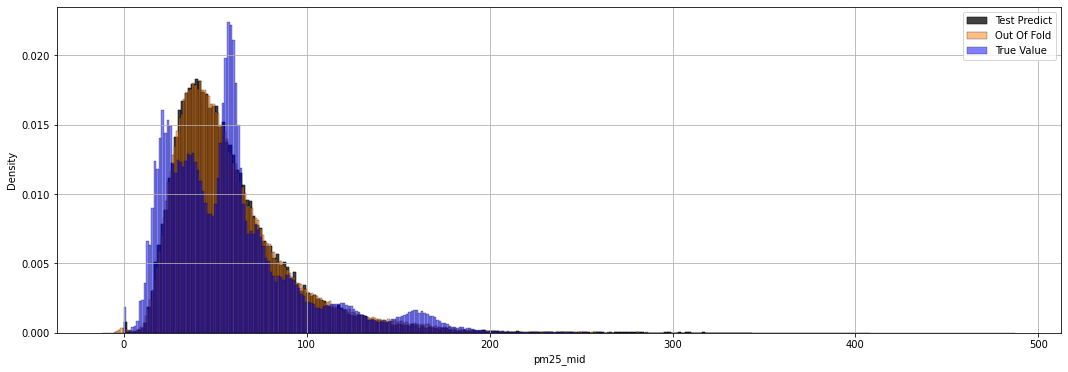

In [ ]:
plot_prediction_distribution(target, oof_valid_lgb1, pred_test)

In [ ]:
submission = pd.read_csv(os.path.join(Input, 'submit_sample.csv'), header=None)
submission.iloc[:, 1] = pred_test
submission

,0,1
0,195942,17.558893
1,195943,36.572141
2,195944,24.297047
3,195945,60.072106
4,195946,129.433330
...,...,...
53504,249446,79.539076
53505,249447,91.769693
53506,249448,57.544421
53507,249449,35.762536


In [ ]:
submission.to_csv(os.path.join(Submission, 'sub.csv'), index=False)